# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

# mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

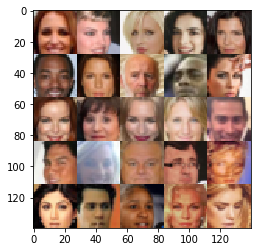

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels),name = "input_real")
    input_z = tf.placeholder(tf.float32,(None,z_dim),name = "input_z")
    learning_rate = tf.placeholder(tf.float32, name = "learning_rate")

    return input_real, input_z, learning_rate 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
        # TODO: Implement Function
    keep_prob = 0.8
    with tf.variable_scope('discriminator', reuse = reuse):
        # input size 28*28*3
        layer1 = tf.layers.conv2d(images, 64, 5, strides = 2,padding = 'same')
        relu1 = tf.maximum(0.12*layer1,layer1)

        # 14*14*64
        layer2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        layer2 = tf.nn.dropout(layer2, keep_prob=keep_prob)
        layer2 = tf.layers.batch_normalization(layer2, training = True)
        relu2 = tf.maximum(0.12*layer2,layer2)

        # 7*7*128
        layer3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        layer3 = tf.nn.dropout(layer3, keep_prob=keep_prob)
        layer3 = tf.layers.batch_normalization(layer3, training= True)
        relu3 = tf.maximum(0.12*layer3,layer3)

        flatten_layer = tf.reshape(relu3, (-1,4*4*256))
        flatten_layer = tf.layers.dropout(flatten_layer, rate=0.3)
        logits = tf.layers.dense(flatten_layer,1)
        
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        layer1 = tf.layers.dense(z,7*7*512);
        layer1 = tf.reshape(layer1,(-1,7,7,512))
        relu1 = tf.maximum(0.2*layer1,layer1)
        relu1 = tf.nn.dropout(relu1,keep_prob=0.8)
        
        # input 7*7*512
        layer2 = tf.layers.conv2d_transpose(relu1,256,5,strides=1,padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training = is_train)
        relu2 = tf.maximum(0.2*layer2,layer2)
        # output 7*7*256
        relu2 = tf.nn.dropout(relu2,keep_prob=0.8)
        
        layer3 = tf.layers.conv2d_transpose(relu2,128,5,strides=2,padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training = is_train)
        relu3  = tf.maximum(0.2*layer3,layer3)
        # 14*14*128
        
        logits = tf.layers.conv2d_transpose(relu3,out_channel_dim,5,strides=2,padding='same')
        output = tf.tanh(logits)
        
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                step+=1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_optimizer, feed_dict = {input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_optimizer, feed_dict = {input_real:batch_images, input_z: batch_z, lr:learning_rate})
                
                if step%10==0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}".format(epoch_i),
                          "The No. {} steps loss_d is {}".format(step,train_loss_d),
                          "The No. {} steps loss_g is {}".format(step,train_loss_g))
                    
                if step%100==0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [15]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 0 The No. 10 steps loss_d is 0.4958476424217224 The No. 10 steps loss_g is 3.634113311767578
Epoch 0 The No. 20 steps loss_d is 0.7558718919754028 The No. 20 steps loss_g is 1.6051383018493652
Epoch 0 The No. 30 steps loss_d is 0.9318548440933228 The No. 30 steps loss_g is 1.539865493774414
Epoch 0 The No. 40 steps loss_d is 0.4213811457157135 The No. 40 steps loss_g is 4.691340446472168
Epoch 0 The No. 50 steps loss_d is 1.0933996438980103 The No. 50 steps loss_g is 1.5784246921539307
Epoch 0 The No. 60 steps loss_d is 0.6713694930076599 The No. 60 steps loss_g is 2.342517852783203
Epoch 0 The No. 70 steps loss_d is 1.3589937686920166 The No. 70 steps loss_g is 0.6566328406333923
Epoch 0 The No. 80 steps loss_d is 0.6191128492355347 The No. 80 steps loss_g is 2.300375461578369
Epoch 0 The No. 90 steps loss_d is 0.569953203201294 The No. 90 steps loss_g is 2.6890320777893066
Epoch 0 The No. 100 steps loss_d is 0.5244097709655762 The No. 100 steps loss_g is 3.445058584213257


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 0 The No. 110 steps loss_d is 0.6234861612319946 The No. 110 steps loss_g is 1.7219922542572021
Epoch 0 The No. 120 steps loss_d is 0.5506545305252075 The No. 120 steps loss_g is 2.370507001876831
Epoch 0 The No. 130 steps loss_d is 0.520155668258667 The No. 130 steps loss_g is 2.6969099044799805
Epoch 0 The No. 140 steps loss_d is 0.5532276630401611 The No. 140 steps loss_g is 2.1545159816741943
Epoch 0 The No. 150 steps loss_d is 0.4419776201248169 The No. 150 steps loss_g is 4.4943952560424805
Epoch 0 The No. 160 steps loss_d is 0.41795477271080017 The No. 160 steps loss_g is 4.3971662521362305
Epoch 0 The No. 170 steps loss_d is 1.7376052141189575 The No. 170 steps loss_g is 0.4537707567214966
Epoch 0 The No. 180 steps loss_d is 0.6136488318443298 The No. 180 steps loss_g is 2.208352565765381
Epoch 0 The No. 190 steps loss_d is 0.4952821731567383 The No. 190 steps loss_g is 2.733180522918701
Epoch 0 The No. 200 steps loss_d is 0.6297541856765747 The No. 200 steps loss_g is 2.

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 0 The No. 210 steps loss_d is 0.4899110794067383 The No. 210 steps loss_g is 5.080761909484863
Epoch 0 The No. 220 steps loss_d is 0.43452921509742737 The No. 220 steps loss_g is 3.334693431854248
Epoch 0 The No. 230 steps loss_d is 0.6249666810035706 The No. 230 steps loss_g is 3.314236879348755
Epoch 0 The No. 240 steps loss_d is 0.44890761375427246 The No. 240 steps loss_g is 3.2675352096557617
Epoch 0 The No. 250 steps loss_d is 0.4445657730102539 The No. 250 steps loss_g is 3.7178597450256348
Epoch 0 The No. 260 steps loss_d is 0.503080427646637 The No. 260 steps loss_g is 2.806734323501587
Epoch 0 The No. 270 steps loss_d is 0.43154042959213257 The No. 270 steps loss_g is 5.234832763671875
Epoch 0 The No. 280 steps loss_d is 0.8251751661300659 The No. 280 steps loss_g is 2.3572916984558105
Epoch 0 The No. 290 steps loss_d is 1.6979176998138428 The No. 290 steps loss_g is 0.7586804032325745
Epoch 0 The No. 300 steps loss_d is 0.5997545719146729 The No. 300 steps loss_g is 2.

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 0 The No. 310 steps loss_d is 0.6628453731536865 The No. 310 steps loss_g is 1.9781192541122437
Epoch 0 The No. 320 steps loss_d is 0.5093638300895691 The No. 320 steps loss_g is 2.889979839324951
Epoch 0 The No. 330 steps loss_d is 2.187229871749878 The No. 330 steps loss_g is 4.629133224487305
Epoch 0 The No. 340 steps loss_d is 1.3103229999542236 The No. 340 steps loss_g is 0.801901638507843
Epoch 0 The No. 350 steps loss_d is 0.6508000493049622 The No. 350 steps loss_g is 1.6939224004745483
Epoch 0 The No. 360 steps loss_d is 0.7349764108657837 The No. 360 steps loss_g is 1.3539726734161377
Epoch 0 The No. 370 steps loss_d is 0.7774642705917358 The No. 370 steps loss_g is 1.594148874282837
Epoch 0 The No. 380 steps loss_d is 0.7414098381996155 The No. 380 steps loss_g is 2.184176445007324
Epoch 0 The No. 390 steps loss_d is 0.4377598464488983 The No. 390 steps loss_g is 3.525362491607666
Epoch 0 The No. 400 steps loss_d is 0.9753697514533997 The No. 400 steps loss_g is 1.7337

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 0 The No. 410 steps loss_d is 0.9156397581100464 The No. 410 steps loss_g is 1.1842033863067627
Epoch 0 The No. 420 steps loss_d is 0.838087797164917 The No. 420 steps loss_g is 1.4696252346038818
Epoch 0 The No. 430 steps loss_d is 0.48945122957229614 The No. 430 steps loss_g is 2.478865146636963
Epoch 0 The No. 440 steps loss_d is 0.585050106048584 The No. 440 steps loss_g is 2.00949764251709
Epoch 0 The No. 450 steps loss_d is 0.47262629866600037 The No. 450 steps loss_g is 2.792135715484619
Epoch 0 The No. 460 steps loss_d is 1.5718040466308594 The No. 460 steps loss_g is 0.5844554901123047
Epoch 1 The No. 10 steps loss_d is 0.6398767828941345 The No. 10 steps loss_g is 2.4841647148132324
Epoch 1 The No. 20 steps loss_d is 0.4459128975868225 The No. 20 steps loss_g is 3.1258139610290527
Epoch 1 The No. 30 steps loss_d is 8.004339218139648 The No. 30 steps loss_g is 9.104913711547852
Epoch 1 The No. 40 steps loss_d is 0.9908971190452576 The No. 40 steps loss_g is 0.98324698209

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1 The No. 110 steps loss_d is 0.45900827646255493 The No. 110 steps loss_g is 2.7799434661865234
Epoch 1 The No. 120 steps loss_d is 0.592440128326416 The No. 120 steps loss_g is 2.0228257179260254
Epoch 1 The No. 130 steps loss_d is 0.8512930870056152 The No. 130 steps loss_g is 2.989781379699707
Epoch 1 The No. 140 steps loss_d is 0.9265618324279785 The No. 140 steps loss_g is 1.3275822401046753
Epoch 1 The No. 150 steps loss_d is 0.6523808240890503 The No. 150 steps loss_g is 1.6739165782928467
Epoch 1 The No. 160 steps loss_d is 0.5008460879325867 The No. 160 steps loss_g is 2.2760939598083496
Epoch 1 The No. 170 steps loss_d is 0.4760339856147766 The No. 170 steps loss_g is 2.643342971801758
Epoch 1 The No. 180 steps loss_d is 0.4380490183830261 The No. 180 steps loss_g is 2.856205463409424
Epoch 1 The No. 190 steps loss_d is 0.4105597138404846 The No. 190 steps loss_g is 3.7466962337493896
Epoch 1 The No. 200 steps loss_d is 1.109663486480713 The No. 200 steps loss_g is 2.8

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1 The No. 210 steps loss_d is 0.5601610541343689 The No. 210 steps loss_g is 2.121778964996338
Epoch 1 The No. 220 steps loss_d is 0.553898811340332 The No. 220 steps loss_g is 2.1170711517333984
Epoch 1 The No. 230 steps loss_d is 0.5148630142211914 The No. 230 steps loss_g is 2.7726709842681885
Epoch 1 The No. 240 steps loss_d is 1.483724594116211 The No. 240 steps loss_g is 0.7046314477920532
Epoch 1 The No. 250 steps loss_d is 0.5162542462348938 The No. 250 steps loss_g is 2.7923192977905273
Epoch 1 The No. 260 steps loss_d is 0.39153096079826355 The No. 260 steps loss_g is 5.140528678894043
Epoch 1 The No. 270 steps loss_d is 0.3837466835975647 The No. 270 steps loss_g is 3.8072900772094727
Epoch 1 The No. 280 steps loss_d is 0.43775153160095215 The No. 280 steps loss_g is 2.91035795211792
Epoch 1 The No. 290 steps loss_d is 0.37464573979377747 The No. 290 steps loss_g is 4.034541130065918
Epoch 1 The No. 300 steps loss_d is 0.5915000438690186 The No. 300 steps loss_g is 2.0

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1 The No. 310 steps loss_d is 0.7236800193786621 The No. 310 steps loss_g is 1.6404781341552734
Epoch 1 The No. 320 steps loss_d is 1.0982005596160889 The No. 320 steps loss_g is 1.3704476356506348
Epoch 1 The No. 330 steps loss_d is 0.9602015614509583 The No. 330 steps loss_g is 1.0707861185073853
Epoch 1 The No. 340 steps loss_d is 0.5661503672599792 The No. 340 steps loss_g is 2.119080066680908
Epoch 1 The No. 350 steps loss_d is 0.6411738395690918 The No. 350 steps loss_g is 2.9013214111328125
Epoch 1 The No. 360 steps loss_d is 1.2022383213043213 The No. 360 steps loss_g is 0.9794729351997375
Epoch 1 The No. 370 steps loss_d is 0.7900283336639404 The No. 370 steps loss_g is 1.9844930171966553
Epoch 1 The No. 380 steps loss_d is 0.9065006375312805 The No. 380 steps loss_g is 2.591742515563965
Epoch 1 The No. 390 steps loss_d is 0.5592600107192993 The No. 390 steps loss_g is 1.950551986694336
Epoch 1 The No. 400 steps loss_d is 0.5947277545928955 The No. 400 steps loss_g is 1.

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1 The No. 410 steps loss_d is 0.5953389406204224 The No. 410 steps loss_g is 2.3128106594085693
Epoch 1 The No. 420 steps loss_d is 0.37611329555511475 The No. 420 steps loss_g is 4.122955799102783
Epoch 1 The No. 430 steps loss_d is 0.3757469356060028 The No. 430 steps loss_g is 5.028652191162109
Epoch 1 The No. 440 steps loss_d is 0.42551955580711365 The No. 440 steps loss_g is 4.685690402984619
Epoch 1 The No. 450 steps loss_d is 0.34474512934684753 The No. 450 steps loss_g is 6.466420650482178
Epoch 1 The No. 460 steps loss_d is 0.7014175653457642 The No. 460 steps loss_g is 1.6120684146881104


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0 The No. 10 steps loss_d is 0.9242905378341675 The No. 10 steps loss_g is 1.3320212364196777
Epoch 0 The No. 20 steps loss_d is 0.6483081579208374 The No. 20 steps loss_g is 1.9896211624145508
Epoch 0 The No. 30 steps loss_d is 0.5522278547286987 The No. 30 steps loss_g is 3.009596347808838
Epoch 0 The No. 40 steps loss_d is 0.43626323342323303 The No. 40 steps loss_g is 3.0569355487823486
Epoch 0 The No. 50 steps loss_d is 0.48706766963005066 The No. 50 steps loss_g is 3.996901035308838
Epoch 0 The No. 60 steps loss_d is 0.6130566000938416 The No. 60 steps loss_g is 2.484719753265381
Epoch 0 The No. 70 steps loss_d is 0.6854984760284424 The No. 70 steps loss_g is 1.612510085105896
Epoch 0 The No. 80 steps loss_d is 1.0363372564315796 The No. 80 steps loss_g is 1.2477322816848755
Epoch 0 The No. 90 steps loss_d is 0.5330752730369568 The No. 90 steps loss_g is 2.443591594696045
Epoch 0 The No. 100 steps loss_d is 0.4514835476875305 The No. 100 steps loss_g is 4.276556015014648


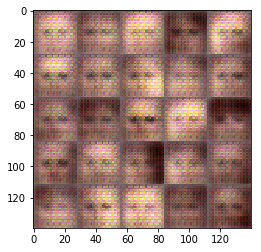

Epoch 0 The No. 110 steps loss_d is 0.43864741921424866 The No. 110 steps loss_g is 2.9585561752319336
Epoch 0 The No. 120 steps loss_d is 0.41776779294013977 The No. 120 steps loss_g is 3.336312770843506
Epoch 0 The No. 130 steps loss_d is 0.45227017998695374 The No. 130 steps loss_g is 5.910482406616211
Epoch 0 The No. 140 steps loss_d is 0.39862892031669617 The No. 140 steps loss_g is 3.8997631072998047
Epoch 0 The No. 150 steps loss_d is 0.4503527879714966 The No. 150 steps loss_g is 4.164617538452148
Epoch 0 The No. 160 steps loss_d is 0.4376818537712097 The No. 160 steps loss_g is 4.213521480560303
Epoch 0 The No. 170 steps loss_d is 0.4276900291442871 The No. 170 steps loss_g is 2.942023277282715
Epoch 0 The No. 180 steps loss_d is 0.4400252103805542 The No. 180 steps loss_g is 3.4592044353485107
Epoch 0 The No. 190 steps loss_d is 0.4501836895942688 The No. 190 steps loss_g is 3.0132546424865723
Epoch 0 The No. 200 steps loss_d is 0.42459115386009216 The No. 200 steps loss_g is

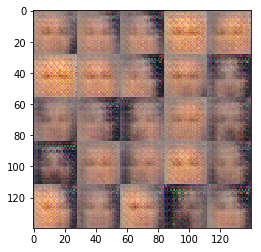

Epoch 0 The No. 210 steps loss_d is 0.7705725431442261 The No. 210 steps loss_g is 1.3530876636505127
Epoch 0 The No. 220 steps loss_d is 3.514927864074707 The No. 220 steps loss_g is 0.18636415898799896
Epoch 0 The No. 230 steps loss_d is 1.1555650234222412 The No. 230 steps loss_g is 1.015665054321289
Epoch 0 The No. 240 steps loss_d is 0.4724271297454834 The No. 240 steps loss_g is 3.826794147491455
Epoch 0 The No. 250 steps loss_d is 0.5600230693817139 The No. 250 steps loss_g is 3.545574188232422
Epoch 0 The No. 260 steps loss_d is 0.3863835632801056 The No. 260 steps loss_g is 4.730124473571777
Epoch 0 The No. 270 steps loss_d is 0.5127151012420654 The No. 270 steps loss_g is 4.527888298034668
Epoch 0 The No. 280 steps loss_d is 0.39725223183631897 The No. 280 steps loss_g is 5.475268840789795
Epoch 0 The No. 290 steps loss_d is 0.4675673544406891 The No. 290 steps loss_g is 2.7775847911834717
Epoch 0 The No. 300 steps loss_d is 0.5012246370315552 The No. 300 steps loss_g is 2.34

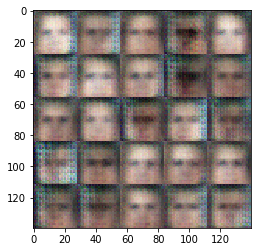

Epoch 0 The No. 310 steps loss_d is 0.5914648771286011 The No. 310 steps loss_g is 2.436767578125
Epoch 0 The No. 320 steps loss_d is 0.4711236357688904 The No. 320 steps loss_g is 2.742103099822998
Epoch 0 The No. 330 steps loss_d is 2.378215789794922 The No. 330 steps loss_g is 7.507044315338135
Epoch 0 The No. 340 steps loss_d is 1.010254144668579 The No. 340 steps loss_g is 1.4797122478485107
Epoch 0 The No. 350 steps loss_d is 0.6155754327774048 The No. 350 steps loss_g is 1.958489179611206
Epoch 0 The No. 360 steps loss_d is 1.7531335353851318 The No. 360 steps loss_g is 0.41015875339508057
Epoch 0 The No. 370 steps loss_d is 0.5497179627418518 The No. 370 steps loss_g is 5.6383514404296875
Epoch 0 The No. 380 steps loss_d is 2.2279458045959473 The No. 380 steps loss_g is 0.226270854473114
Epoch 0 The No. 390 steps loss_d is 0.9424535036087036 The No. 390 steps loss_g is 0.9361886382102966
Epoch 0 The No. 400 steps loss_d is 0.6926730871200562 The No. 400 steps loss_g is 1.461062

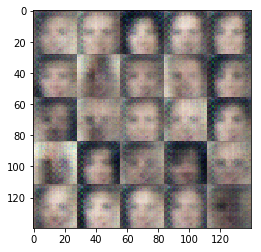

Epoch 0 The No. 410 steps loss_d is 0.3563486933708191 The No. 410 steps loss_g is 6.484555244445801
Epoch 0 The No. 420 steps loss_d is 0.44788825511932373 The No. 420 steps loss_g is 4.44050931930542
Epoch 0 The No. 430 steps loss_d is 0.43346697092056274 The No. 430 steps loss_g is 3.290254592895508
Epoch 0 The No. 440 steps loss_d is 0.6095433235168457 The No. 440 steps loss_g is 4.851759910583496
Epoch 0 The No. 450 steps loss_d is 0.5721170902252197 The No. 450 steps loss_g is 2.275481939315796
Epoch 0 The No. 460 steps loss_d is 0.36277249455451965 The No. 460 steps loss_g is 5.973705291748047
Epoch 0 The No. 470 steps loss_d is 0.6852224469184875 The No. 470 steps loss_g is 1.527160882949829
Epoch 0 The No. 480 steps loss_d is 0.3561655580997467 The No. 480 steps loss_g is 6.620987892150879
Epoch 0 The No. 490 steps loss_d is 0.3982539474964142 The No. 490 steps loss_g is 4.205972194671631
Epoch 0 The No. 500 steps loss_d is 0.35197576880455017 The No. 500 steps loss_g is 7.289

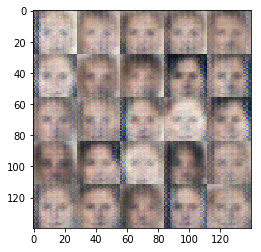

Epoch 0 The No. 510 steps loss_d is 0.4004845917224884 The No. 510 steps loss_g is 4.079227447509766
Epoch 0 The No. 520 steps loss_d is 1.2413015365600586 The No. 520 steps loss_g is 0.6542814373970032
Epoch 0 The No. 530 steps loss_d is 0.6823906302452087 The No. 530 steps loss_g is 5.8650007247924805
Epoch 0 The No. 540 steps loss_d is 0.38918963074684143 The No. 540 steps loss_g is 3.777270793914795
Epoch 0 The No. 550 steps loss_d is 0.40943479537963867 The No. 550 steps loss_g is 3.5479774475097656
Epoch 0 The No. 560 steps loss_d is 0.5163263082504272 The No. 560 steps loss_g is 2.1768743991851807
Epoch 0 The No. 570 steps loss_d is 0.45627424120903015 The No. 570 steps loss_g is 6.818565845489502
Epoch 0 The No. 580 steps loss_d is 0.36298251152038574 The No. 580 steps loss_g is 6.306150436401367
Epoch 0 The No. 590 steps loss_d is 0.35783636569976807 The No. 590 steps loss_g is 7.094014644622803
Epoch 0 The No. 600 steps loss_d is 0.3952866792678833 The No. 600 steps loss_g is

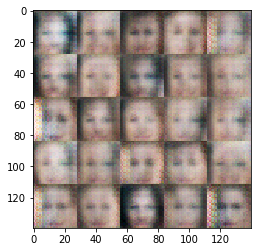

Epoch 0 The No. 610 steps loss_d is 0.35094884037971497 The No. 610 steps loss_g is 9.27380084991455
Epoch 0 The No. 620 steps loss_d is 0.40678176283836365 The No. 620 steps loss_g is 4.102602958679199
Epoch 0 The No. 630 steps loss_d is 0.35438036918640137 The No. 630 steps loss_g is 5.25672721862793
Epoch 0 The No. 640 steps loss_d is 0.46351924538612366 The No. 640 steps loss_g is 2.76285982131958
Epoch 0 The No. 650 steps loss_d is 0.5968447327613831 The No. 650 steps loss_g is 7.50506591796875
Epoch 0 The No. 660 steps loss_d is 0.3564428687095642 The No. 660 steps loss_g is 5.292086124420166
Epoch 0 The No. 670 steps loss_d is 0.36528944969177246 The No. 670 steps loss_g is 5.463802337646484
Epoch 0 The No. 680 steps loss_d is 1.7540512084960938 The No. 680 steps loss_g is 9.429389953613281
Epoch 0 The No. 690 steps loss_d is 0.41074734926223755 The No. 690 steps loss_g is 4.61285400390625
Epoch 0 The No. 700 steps loss_d is 0.3715599477291107 The No. 700 steps loss_g is 4.04478

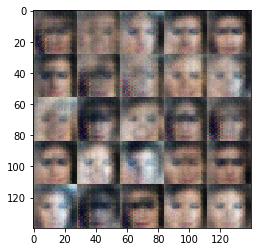

Epoch 0 The No. 710 steps loss_d is 0.6253265142440796 The No. 710 steps loss_g is 2.7879676818847656
Epoch 0 The No. 720 steps loss_d is 0.3648484945297241 The No. 720 steps loss_g is 4.923337936401367
Epoch 0 The No. 730 steps loss_d is 0.36571505665779114 The No. 730 steps loss_g is 5.373224258422852
Epoch 0 The No. 740 steps loss_d is 0.34664925932884216 The No. 740 steps loss_g is 6.355512619018555
Epoch 0 The No. 750 steps loss_d is 0.3551720082759857 The No. 750 steps loss_g is 5.386082649230957
Epoch 0 The No. 760 steps loss_d is 0.35396066308021545 The No. 760 steps loss_g is 4.723876953125
Epoch 0 The No. 770 steps loss_d is 0.6710529327392578 The No. 770 steps loss_g is 1.4288415908813477
Epoch 0 The No. 780 steps loss_d is 0.4698103666305542 The No. 780 steps loss_g is 2.5263612270355225
Epoch 0 The No. 790 steps loss_d is 0.36474353075027466 The No. 790 steps loss_g is 4.679751396179199
Epoch 0 The No. 800 steps loss_d is 0.35633838176727295 The No. 800 steps loss_g is 6.6

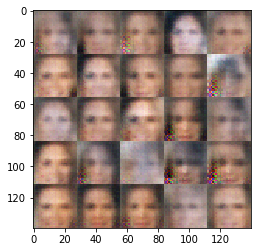

Epoch 0 The No. 810 steps loss_d is 0.47680091857910156 The No. 810 steps loss_g is 2.7724227905273438
Epoch 0 The No. 820 steps loss_d is 0.4148053824901581 The No. 820 steps loss_g is 5.662421226501465
Epoch 0 The No. 830 steps loss_d is 0.387288361787796 The No. 830 steps loss_g is 7.6824727058410645
Epoch 0 The No. 840 steps loss_d is 0.3890987038612366 The No. 840 steps loss_g is 3.6239755153656006
Epoch 0 The No. 850 steps loss_d is 0.3455650210380554 The No. 850 steps loss_g is 5.432642459869385
Epoch 0 The No. 860 steps loss_d is 0.35313907265663147 The No. 860 steps loss_g is 6.416859149932861
Epoch 0 The No. 870 steps loss_d is 0.3548610210418701 The No. 870 steps loss_g is 7.015393257141113
Epoch 0 The No. 880 steps loss_d is 0.4315815269947052 The No. 880 steps loss_g is 5.772229194641113
Epoch 0 The No. 890 steps loss_d is 0.3840351700782776 The No. 890 steps loss_g is 4.0786452293396
Epoch 0 The No. 900 steps loss_d is 0.9857301712036133 The No. 900 steps loss_g is 0.7624

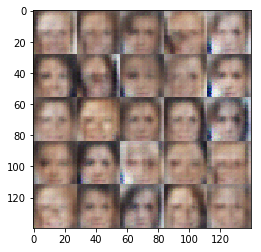

Epoch 0 The No. 910 steps loss_d is 0.4170163869857788 The No. 910 steps loss_g is 4.68400764465332
Epoch 0 The No. 920 steps loss_d is 0.4402414560317993 The No. 920 steps loss_g is 3.182640552520752
Epoch 0 The No. 930 steps loss_d is 0.6107492446899414 The No. 930 steps loss_g is 2.0634241104125977
Epoch 0 The No. 940 steps loss_d is 0.35024169087409973 The No. 940 steps loss_g is 6.47989559173584
Epoch 0 The No. 950 steps loss_d is 0.35235631465911865 The No. 950 steps loss_g is 5.756240367889404
Epoch 0 The No. 960 steps loss_d is 0.391460657119751 The No. 960 steps loss_g is 6.182039260864258
Epoch 0 The No. 970 steps loss_d is 0.3501909375190735 The No. 970 steps loss_g is 6.8861236572265625
Epoch 0 The No. 980 steps loss_d is 0.4183208644390106 The No. 980 steps loss_g is 3.1658272743225098
Epoch 0 The No. 990 steps loss_d is 0.45942625403404236 The No. 990 steps loss_g is 3.569232940673828
Epoch 0 The No. 1000 steps loss_d is 0.37006238102912903 The No. 1000 steps loss_g is 6.

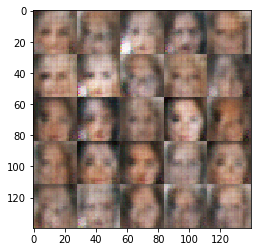

Epoch 0 The No. 1010 steps loss_d is 0.5936071276664734 The No. 1010 steps loss_g is 5.458609580993652
Epoch 0 The No. 1020 steps loss_d is 0.34498119354248047 The No. 1020 steps loss_g is 7.36421012878418
Epoch 0 The No. 1030 steps loss_d is 0.3549787402153015 The No. 1030 steps loss_g is 4.795267581939697
Epoch 0 The No. 1040 steps loss_d is 0.4510064125061035 The No. 1040 steps loss_g is 2.9399797916412354
Epoch 0 The No. 1050 steps loss_d is 0.4732069969177246 The No. 1050 steps loss_g is 2.4694366455078125
Epoch 0 The No. 1060 steps loss_d is 0.36213943362236023 The No. 1060 steps loss_g is 7.500466823577881
Epoch 0 The No. 1070 steps loss_d is 0.3540888726711273 The No. 1070 steps loss_g is 5.181394577026367
Epoch 0 The No. 1080 steps loss_d is 0.37248873710632324 The No. 1080 steps loss_g is 5.312932014465332
Epoch 0 The No. 1090 steps loss_d is 0.47424712777137756 The No. 1090 steps loss_g is 3.130523204803467
Epoch 0 The No. 1100 steps loss_d is 0.40698549151420593 The No. 110

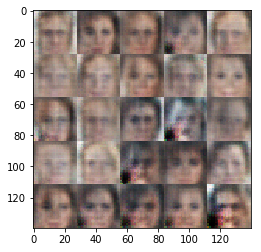

Epoch 0 The No. 1110 steps loss_d is 0.36041945219039917 The No. 1110 steps loss_g is 5.501344680786133
Epoch 0 The No. 1120 steps loss_d is 0.37914174795150757 The No. 1120 steps loss_g is 4.689460754394531
Epoch 0 The No. 1130 steps loss_d is 0.5522691607475281 The No. 1130 steps loss_g is 2.143845796585083
Epoch 0 The No. 1140 steps loss_d is 0.3489338159561157 The No. 1140 steps loss_g is 9.55240535736084
Epoch 0 The No. 1150 steps loss_d is 0.36292731761932373 The No. 1150 steps loss_g is 5.410828590393066
Epoch 0 The No. 1160 steps loss_d is 0.4198616147041321 The No. 1160 steps loss_g is 3.6667122840881348
Epoch 0 The No. 1170 steps loss_d is 0.3603401482105255 The No. 1170 steps loss_g is 4.951030731201172
Epoch 0 The No. 1180 steps loss_d is 0.4195322096347809 The No. 1180 steps loss_g is 8.605524063110352
Epoch 0 The No. 1190 steps loss_d is 0.3414839804172516 The No. 1190 steps loss_g is 8.307304382324219
Epoch 0 The No. 1200 steps loss_d is 0.3581482768058777 The No. 1200 s

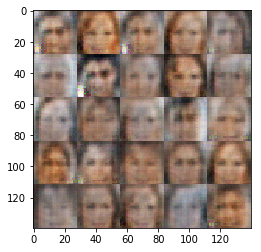

Epoch 0 The No. 1210 steps loss_d is 0.34305983781814575 The No. 1210 steps loss_g is 7.41242790222168
Epoch 0 The No. 1220 steps loss_d is 0.3566383719444275 The No. 1220 steps loss_g is 5.225786209106445
Epoch 0 The No. 1230 steps loss_d is 0.3446089029312134 The No. 1230 steps loss_g is 6.85358190536499
Epoch 0 The No. 1240 steps loss_d is 0.347913533449173 The No. 1240 steps loss_g is 7.688412189483643
Epoch 0 The No. 1250 steps loss_d is 0.34009841084480286 The No. 1250 steps loss_g is 8.366616249084473
Epoch 0 The No. 1260 steps loss_d is 0.4189894497394562 The No. 1260 steps loss_g is 3.01894474029541
Epoch 0 The No. 1270 steps loss_d is 0.4249727129936218 The No. 1270 steps loss_g is 6.385445594787598
Epoch 0 The No. 1280 steps loss_d is 0.344383180141449 The No. 1280 steps loss_g is 7.416997909545898
Epoch 0 The No. 1290 steps loss_d is 0.3564057946205139 The No. 1290 steps loss_g is 6.196628570556641
Epoch 0 The No. 1300 steps loss_d is 0.34489452838897705 The No. 1300 steps 

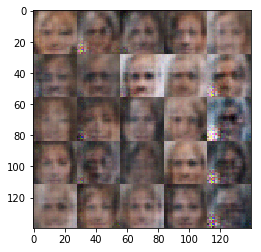

Epoch 0 The No. 1310 steps loss_d is 0.3639008104801178 The No. 1310 steps loss_g is 6.097662448883057
Epoch 0 The No. 1320 steps loss_d is 0.6519092321395874 The No. 1320 steps loss_g is 2.0781702995300293
Epoch 0 The No. 1330 steps loss_d is 0.4506247043609619 The No. 1330 steps loss_g is 3.8893887996673584
Epoch 0 The No. 1340 steps loss_d is 0.5699106454849243 The No. 1340 steps loss_g is 2.968090295791626
Epoch 0 The No. 1350 steps loss_d is 0.3866761326789856 The No. 1350 steps loss_g is 6.366887092590332
Epoch 0 The No. 1360 steps loss_d is 0.3618982434272766 The No. 1360 steps loss_g is 7.356979846954346
Epoch 0 The No. 1370 steps loss_d is 0.34884101152420044 The No. 1370 steps loss_g is 8.338940620422363
Epoch 0 The No. 1380 steps loss_d is 0.3501732051372528 The No. 1380 steps loss_g is 5.018962383270264
Epoch 0 The No. 1390 steps loss_d is 1.0418305397033691 The No. 1390 steps loss_g is 0.8629485964775085
Epoch 0 The No. 1400 steps loss_d is 0.6152002811431885 The No. 1400 

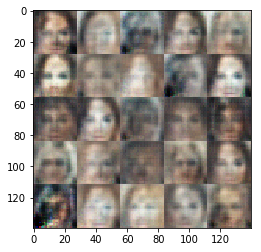

Epoch 0 The No. 1410 steps loss_d is 0.34446781873703003 The No. 1410 steps loss_g is 8.284202575683594
Epoch 0 The No. 1420 steps loss_d is 0.6254764199256897 The No. 1420 steps loss_g is 2.777864933013916
Epoch 0 The No. 1430 steps loss_d is 0.3460683822631836 The No. 1430 steps loss_g is 8.882680892944336
Epoch 0 The No. 1440 steps loss_d is 0.347810298204422 The No. 1440 steps loss_g is 6.8230085372924805
Epoch 0 The No. 1450 steps loss_d is 0.35046425461769104 The No. 1450 steps loss_g is 6.363170146942139
Epoch 0 The No. 1460 steps loss_d is 0.3641950488090515 The No. 1460 steps loss_g is 8.592591285705566
Epoch 0 The No. 1470 steps loss_d is 0.34350496530532837 The No. 1470 steps loss_g is 6.969355583190918
Epoch 0 The No. 1480 steps loss_d is 0.35236790776252747 The No. 1480 steps loss_g is 5.995326042175293
Epoch 0 The No. 1490 steps loss_d is 0.33976486325263977 The No. 1490 steps loss_g is 9.3659086227417
Epoch 0 The No. 1500 steps loss_d is 0.4147953987121582 The No. 1500 s

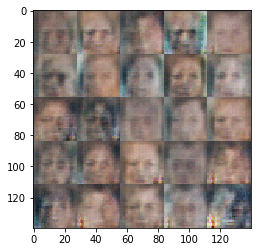

Epoch 0 The No. 1510 steps loss_d is 0.34725692868232727 The No. 1510 steps loss_g is 9.256444931030273
Epoch 0 The No. 1520 steps loss_d is 0.338742733001709 The No. 1520 steps loss_g is 7.290150165557861
Epoch 0 The No. 1530 steps loss_d is 0.34778720140457153 The No. 1530 steps loss_g is 6.379035472869873
Epoch 0 The No. 1540 steps loss_d is 0.34435832500457764 The No. 1540 steps loss_g is 8.260506629943848
Epoch 0 The No. 1550 steps loss_d is 0.40032196044921875 The No. 1550 steps loss_g is 3.589982509613037
Epoch 0 The No. 1560 steps loss_d is 0.3699738085269928 The No. 1560 steps loss_g is 5.4290852546691895
Epoch 0 The No. 1570 steps loss_d is 0.35254207253456116 The No. 1570 steps loss_g is 4.318019390106201
Epoch 0 The No. 1580 steps loss_d is 0.3516063392162323 The No. 1580 steps loss_g is 8.683979034423828
Epoch 0 The No. 1590 steps loss_d is 0.3448026478290558 The No. 1590 steps loss_g is 8.697469711303711
Epoch 0 The No. 1600 steps loss_d is 0.35298094153404236 The No. 160

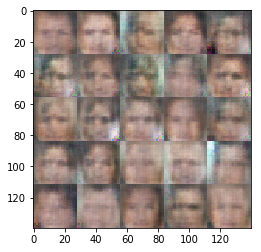

Epoch 0 The No. 1610 steps loss_d is 0.34048014879226685 The No. 1610 steps loss_g is 9.228715896606445
Epoch 0 The No. 1620 steps loss_d is 0.3806506395339966 The No. 1620 steps loss_g is 3.6637141704559326
Epoch 0 The No. 1630 steps loss_d is 2.5051798820495605 The No. 1630 steps loss_g is 7.339730262756348
Epoch 0 The No. 1640 steps loss_d is 0.4898051917552948 The No. 1640 steps loss_g is 2.6811819076538086
Epoch 0 The No. 1650 steps loss_d is 0.35379165410995483 The No. 1650 steps loss_g is 6.084411144256592
Epoch 0 The No. 1660 steps loss_d is 0.40556108951568604 The No. 1660 steps loss_g is 4.196211814880371
Epoch 0 The No. 1670 steps loss_d is 0.3792617917060852 The No. 1670 steps loss_g is 4.148150444030762
Epoch 0 The No. 1680 steps loss_d is 0.7818952798843384 The No. 1680 steps loss_g is 1.2542240619659424
Epoch 0 The No. 1690 steps loss_d is 0.5257166624069214 The No. 1690 steps loss_g is 1.9024195671081543
Epoch 0 The No. 1700 steps loss_d is 1.0676782131195068 The No. 17

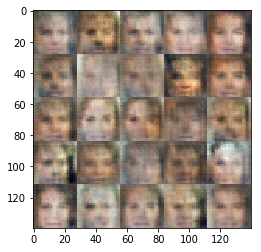

Epoch 0 The No. 1710 steps loss_d is 0.5542060136795044 The No. 1710 steps loss_g is 6.1974005699157715
Epoch 0 The No. 1720 steps loss_d is 0.35405632853507996 The No. 1720 steps loss_g is 8.052040100097656
Epoch 0 The No. 1730 steps loss_d is 0.3791871964931488 The No. 1730 steps loss_g is 5.420815467834473
Epoch 0 The No. 1740 steps loss_d is 0.38597914576530457 The No. 1740 steps loss_g is 3.549665927886963
Epoch 0 The No. 1750 steps loss_d is 0.36566585302352905 The No. 1750 steps loss_g is 5.927879333496094
Epoch 0 The No. 1760 steps loss_d is 0.3471050262451172 The No. 1760 steps loss_g is 10.18283462524414
Epoch 0 The No. 1770 steps loss_d is 0.34394732117652893 The No. 1770 steps loss_g is 8.043505668640137
Epoch 0 The No. 1780 steps loss_d is 0.34000104665756226 The No. 1780 steps loss_g is 7.069883346557617
Epoch 0 The No. 1790 steps loss_d is 0.3486073315143585 The No. 1790 steps loss_g is 4.951104640960693
Epoch 0 The No. 1800 steps loss_d is 0.35367482900619507 The No. 18

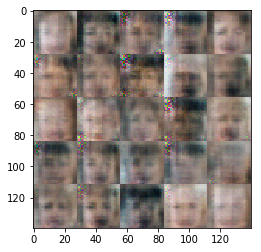

Epoch 0 The No. 1810 steps loss_d is 0.33941909670829773 The No. 1810 steps loss_g is 8.955610275268555
Epoch 0 The No. 1820 steps loss_d is 0.34226974844932556 The No. 1820 steps loss_g is 7.657726287841797
Epoch 0 The No. 1830 steps loss_d is 0.3448811173439026 The No. 1830 steps loss_g is 6.276823043823242
Epoch 0 The No. 1840 steps loss_d is 0.3457687199115753 The No. 1840 steps loss_g is 8.680450439453125
Epoch 0 The No. 1850 steps loss_d is 0.34101831912994385 The No. 1850 steps loss_g is 7.372903347015381
Epoch 0 The No. 1860 steps loss_d is 0.3436605930328369 The No. 1860 steps loss_g is 5.8062028884887695
Epoch 0 The No. 1870 steps loss_d is 0.3398950695991516 The No. 1870 steps loss_g is 8.171009063720703
Epoch 0 The No. 1880 steps loss_d is 0.34074822068214417 The No. 1880 steps loss_g is 7.009618759155273
Epoch 0 The No. 1890 steps loss_d is 0.3402891457080841 The No. 1890 steps loss_g is 8.258793830871582
Epoch 0 The No. 1900 steps loss_d is 0.33964866399765015 The No. 190

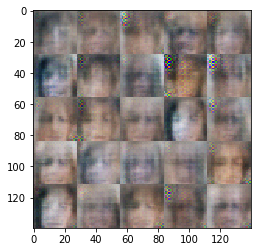

Epoch 0 The No. 1910 steps loss_d is 0.333768755197525 The No. 1910 steps loss_g is 8.714113235473633
Epoch 0 The No. 1920 steps loss_d is 0.3408038914203644 The No. 1920 steps loss_g is 8.301812171936035
Epoch 0 The No. 1930 steps loss_d is 0.3472973704338074 The No. 1930 steps loss_g is 7.204434871673584
Epoch 0 The No. 1940 steps loss_d is 0.33762601017951965 The No. 1940 steps loss_g is 6.786002159118652
Epoch 0 The No. 1950 steps loss_d is 0.3402189612388611 The No. 1950 steps loss_g is 6.482839584350586
Epoch 0 The No. 1960 steps loss_d is 0.345885694026947 The No. 1960 steps loss_g is 5.601104736328125
Epoch 0 The No. 1970 steps loss_d is 0.3437051475048065 The No. 1970 steps loss_g is 5.297062873840332
Epoch 0 The No. 1980 steps loss_d is 0.3472383916378021 The No. 1980 steps loss_g is 4.972978115081787
Epoch 0 The No. 1990 steps loss_d is 0.346767395734787 The No. 1990 steps loss_g is 4.744112014770508
Epoch 0 The No. 2000 steps loss_d is 0.3353552520275116 The No. 2000 steps 

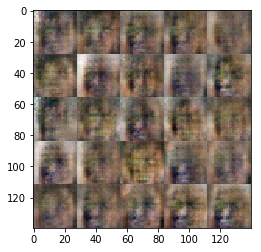

Epoch 0 The No. 2010 steps loss_d is 0.3364908993244171 The No. 2010 steps loss_g is 9.881126403808594
Epoch 0 The No. 2020 steps loss_d is 0.3393857479095459 The No. 2020 steps loss_g is 6.527433395385742
Epoch 0 The No. 2030 steps loss_d is 0.3398969769477844 The No. 2030 steps loss_g is 7.572916030883789
Epoch 0 The No. 2040 steps loss_d is 0.33757099509239197 The No. 2040 steps loss_g is 7.927552223205566
Epoch 0 The No. 2050 steps loss_d is 0.3347492516040802 The No. 2050 steps loss_g is 8.56042766571045
Epoch 0 The No. 2060 steps loss_d is 0.3383747339248657 The No. 2060 steps loss_g is 6.855166912078857
Epoch 0 The No. 2070 steps loss_d is 0.33789530396461487 The No. 2070 steps loss_g is 6.5111188888549805
Epoch 0 The No. 2080 steps loss_d is 0.3404391407966614 The No. 2080 steps loss_g is 5.609950065612793
Epoch 0 The No. 2090 steps loss_d is 0.3366914689540863 The No. 2090 steps loss_g is 8.109106063842773
Epoch 0 The No. 2100 steps loss_d is 0.33554133772850037 The No. 2100 s

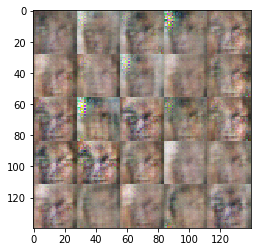

Epoch 0 The No. 2110 steps loss_d is 0.33949196338653564 The No. 2110 steps loss_g is 8.489252090454102
Epoch 0 The No. 2120 steps loss_d is 0.33756738901138306 The No. 2120 steps loss_g is 7.4623565673828125
Epoch 0 The No. 2130 steps loss_d is 0.3379022777080536 The No. 2130 steps loss_g is 6.750199317932129
Epoch 0 The No. 2140 steps loss_d is 0.33478090167045593 The No. 2140 steps loss_g is 7.324216842651367
Epoch 0 The No. 2150 steps loss_d is 0.3354828655719757 The No. 2150 steps loss_g is 6.5414934158325195
Epoch 0 The No. 2160 steps loss_d is 0.33357247710227966 The No. 2160 steps loss_g is 8.597536087036133
Epoch 0 The No. 2170 steps loss_d is 0.33837321400642395 The No. 2170 steps loss_g is 7.5501708984375
Epoch 0 The No. 2180 steps loss_d is 0.3388300836086273 The No. 2180 steps loss_g is 6.9438157081604
Epoch 0 The No. 2190 steps loss_d is 0.3356234133243561 The No. 2190 steps loss_g is 9.128439903259277
Epoch 0 The No. 2200 steps loss_d is 0.33433955907821655 The No. 2200 

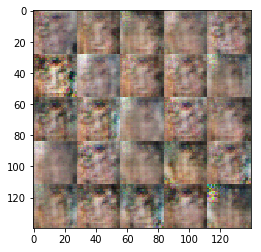

Epoch 0 The No. 2210 steps loss_d is 0.33779972791671753 The No. 2210 steps loss_g is 8.473054885864258
Epoch 0 The No. 2220 steps loss_d is 0.3344583213329315 The No. 2220 steps loss_g is 7.309728145599365
Epoch 0 The No. 2230 steps loss_d is 0.33393770456314087 The No. 2230 steps loss_g is 8.97944450378418
Epoch 0 The No. 2240 steps loss_d is 0.3677710294723511 The No. 2240 steps loss_g is 3.4661221504211426
Epoch 0 The No. 2250 steps loss_d is 0.338297575712204 The No. 2250 steps loss_g is 9.645313262939453
Epoch 0 The No. 2260 steps loss_d is 0.7291525602340698 The No. 2260 steps loss_g is 0.9955578446388245
Epoch 0 The No. 2270 steps loss_d is 0.33524227142333984 The No. 2270 steps loss_g is 7.631762504577637
Epoch 0 The No. 2280 steps loss_d is 0.3370179533958435 The No. 2280 steps loss_g is 6.553560256958008
Epoch 0 The No. 2290 steps loss_d is 0.724751889705658 The No. 2290 steps loss_g is 1.6444227695465088
Epoch 0 The No. 2300 steps loss_d is 0.6299551129341125 The No. 2300 s

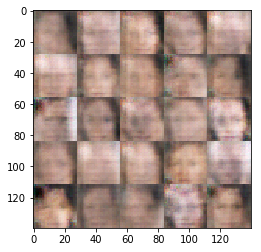

Epoch 0 The No. 2310 steps loss_d is 0.7669624090194702 The No. 2310 steps loss_g is 2.819924831390381
Epoch 0 The No. 2320 steps loss_d is 0.8148586750030518 The No. 2320 steps loss_g is 1.5755946636199951
Epoch 0 The No. 2330 steps loss_d is 1.7352467775344849 The No. 2330 steps loss_g is 6.0407490730285645
Epoch 0 The No. 2340 steps loss_d is 1.3318754434585571 The No. 2340 steps loss_g is 0.5753904581069946
Epoch 0 The No. 2350 steps loss_d is 0.4762391448020935 The No. 2350 steps loss_g is 4.015844821929932
Epoch 0 The No. 2360 steps loss_d is 0.40217989683151245 The No. 2360 steps loss_g is 5.550322532653809
Epoch 0 The No. 2370 steps loss_d is 0.4795856475830078 The No. 2370 steps loss_g is 2.496156692504883
Epoch 0 The No. 2380 steps loss_d is 0.8163150548934937 The No. 2380 steps loss_g is 0.9570221304893494
Epoch 0 The No. 2390 steps loss_d is 1.3045347929000854 The No. 2390 steps loss_g is 0.5735159516334534
Epoch 0 The No. 2400 steps loss_d is 0.6131520867347717 The No. 240

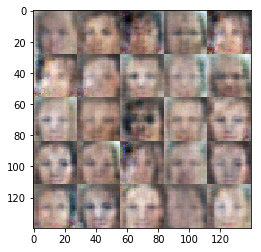

Epoch 0 The No. 2410 steps loss_d is 0.5857235789299011 The No. 2410 steps loss_g is 1.9451645612716675
Epoch 0 The No. 2420 steps loss_d is 1.3124598264694214 The No. 2420 steps loss_g is 3.8518471717834473
Epoch 0 The No. 2430 steps loss_d is 0.35589009523391724 The No. 2430 steps loss_g is 7.130175590515137
Epoch 0 The No. 2440 steps loss_d is 0.4027079641819 The No. 2440 steps loss_g is 8.254822731018066
Epoch 0 The No. 2450 steps loss_d is 0.555717408657074 The No. 2450 steps loss_g is 1.726945161819458
Epoch 0 The No. 2460 steps loss_d is 0.35714974999427795 The No. 2460 steps loss_g is 7.027585029602051
Epoch 0 The No. 2470 steps loss_d is 0.3560446798801422 The No. 2470 steps loss_g is 5.101018905639648
Epoch 0 The No. 2480 steps loss_d is 1.3126729726791382 The No. 2480 steps loss_g is 0.5582634806632996
Epoch 0 The No. 2490 steps loss_d is 0.7110631465911865 The No. 2490 steps loss_g is 3.3786144256591797
Epoch 0 The No. 2500 steps loss_d is 0.35338321328163147 The No. 2500 s

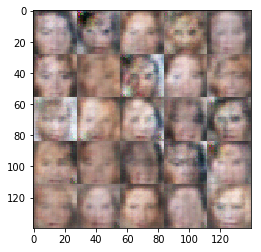

Epoch 0 The No. 2510 steps loss_d is 1.1256321668624878 The No. 2510 steps loss_g is 0.7597929835319519
Epoch 0 The No. 2520 steps loss_d is 0.8808337450027466 The No. 2520 steps loss_g is 1.2130922079086304
Epoch 0 The No. 2530 steps loss_d is 0.5214254260063171 The No. 2530 steps loss_g is 5.261839389801025
Epoch 0 The No. 2540 steps loss_d is 0.3953094482421875 The No. 2540 steps loss_g is 4.510030746459961
Epoch 0 The No. 2550 steps loss_d is 0.37807485461235046 The No. 2550 steps loss_g is 6.207530975341797
Epoch 0 The No. 2560 steps loss_d is 0.3635702133178711 The No. 2560 steps loss_g is 4.3457865715026855
Epoch 0 The No. 2570 steps loss_d is 0.3684041202068329 The No. 2570 steps loss_g is 4.851356029510498
Epoch 0 The No. 2580 steps loss_d is 0.3537267744541168 The No. 2580 steps loss_g is 5.347509384155273
Epoch 0 The No. 2590 steps loss_d is 0.40639933943748474 The No. 2590 steps loss_g is 3.676565647125244
Epoch 0 The No. 2600 steps loss_d is 0.3571777045726776 The No. 2600

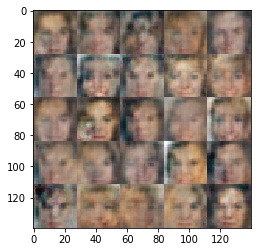

Epoch 0 The No. 2610 steps loss_d is 0.3925086259841919 The No. 2610 steps loss_g is 3.5716166496276855
Epoch 0 The No. 2620 steps loss_d is 0.37625643610954285 The No. 2620 steps loss_g is 6.456843376159668
Epoch 0 The No. 2630 steps loss_d is 0.3485087752342224 The No. 2630 steps loss_g is 7.965966701507568
Epoch 0 The No. 2640 steps loss_d is 0.38093504309654236 The No. 2640 steps loss_g is 5.096282958984375
Epoch 0 The No. 2650 steps loss_d is 1.0769554376602173 The No. 2650 steps loss_g is 8.55958080291748
Epoch 0 The No. 2660 steps loss_d is 0.34930747747421265 The No. 2660 steps loss_g is 7.669863700866699
Epoch 0 The No. 2670 steps loss_d is 0.3448154330253601 The No. 2670 steps loss_g is 8.76685905456543
Epoch 0 The No. 2680 steps loss_d is 1.0267794132232666 The No. 2680 steps loss_g is 0.8711084127426147
Epoch 0 The No. 2690 steps loss_d is 0.3698742985725403 The No. 2690 steps loss_g is 5.718229293823242
Epoch 0 The No. 2700 steps loss_d is 0.3645150661468506 The No. 2700 s

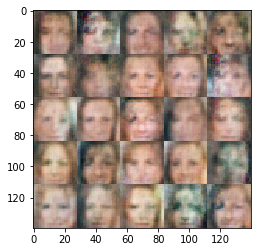

Epoch 0 The No. 2710 steps loss_d is 0.4334043860435486 The No. 2710 steps loss_g is 3.079129219055176
Epoch 0 The No. 2720 steps loss_d is 0.6197957396507263 The No. 2720 steps loss_g is 1.6675864458084106
Epoch 0 The No. 2730 steps loss_d is 0.37314069271087646 The No. 2730 steps loss_g is 7.241433620452881
Epoch 0 The No. 2740 steps loss_d is 0.36059489846229553 The No. 2740 steps loss_g is 5.971832275390625
Epoch 0 The No. 2750 steps loss_d is 0.37560510635375977 The No. 2750 steps loss_g is 3.818580150604248
Epoch 0 The No. 2760 steps loss_d is 1.5614241361618042 The No. 2760 steps loss_g is 5.9434733390808105
Epoch 0 The No. 2770 steps loss_d is 0.5895962715148926 The No. 2770 steps loss_g is 2.269411087036133
Epoch 0 The No. 2780 steps loss_d is 0.4502051770687103 The No. 2780 steps loss_g is 2.4523839950561523
Epoch 0 The No. 2790 steps loss_d is 0.3494872748851776 The No. 2790 steps loss_g is 6.068824768066406
Epoch 0 The No. 2800 steps loss_d is 0.49616318941116333 The No. 28

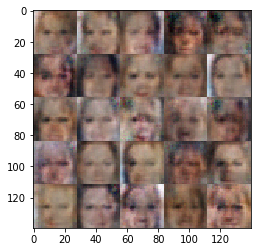

Epoch 0 The No. 2810 steps loss_d is 2.927236557006836 The No. 2810 steps loss_g is 5.926906585693359
Epoch 0 The No. 2820 steps loss_d is 1.104102373123169 The No. 2820 steps loss_g is 1.0700528621673584
Epoch 0 The No. 2830 steps loss_d is 0.669166088104248 The No. 2830 steps loss_g is 1.966461181640625
Epoch 0 The No. 2840 steps loss_d is 0.9319940209388733 The No. 2840 steps loss_g is 1.0366756916046143
Epoch 0 The No. 2850 steps loss_d is 1.0129646062850952 The No. 2850 steps loss_g is 5.851954460144043
Epoch 0 The No. 2860 steps loss_d is 0.7287098169326782 The No. 2860 steps loss_g is 1.53300142288208
Epoch 0 The No. 2870 steps loss_d is 0.6778751611709595 The No. 2870 steps loss_g is 2.967883348464966
Epoch 0 The No. 2880 steps loss_d is 1.0085004568099976 The No. 2880 steps loss_g is 0.948030948638916
Epoch 0 The No. 2890 steps loss_d is 1.2967033386230469 The No. 2890 steps loss_g is 0.6280010938644409
Epoch 0 The No. 2900 steps loss_d is 1.1105763912200928 The No. 2900 steps

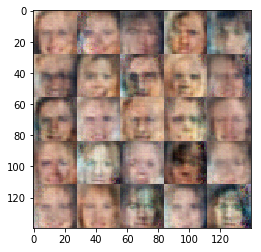

Epoch 0 The No. 2910 steps loss_d is 0.43130311369895935 The No. 2910 steps loss_g is 3.1526684761047363
Epoch 0 The No. 2920 steps loss_d is 0.3978919982910156 The No. 2920 steps loss_g is 5.746575355529785
Epoch 0 The No. 2930 steps loss_d is 0.8602542281150818 The No. 2930 steps loss_g is 1.018601655960083
Epoch 0 The No. 2940 steps loss_d is 0.37285298109054565 The No. 2940 steps loss_g is 6.048684120178223
Epoch 0 The No. 2950 steps loss_d is 1.4741592407226562 The No. 2950 steps loss_g is 6.58472204208374
Epoch 0 The No. 2960 steps loss_d is 0.3809049725532532 The No. 2960 steps loss_g is 6.735264778137207
Epoch 0 The No. 2970 steps loss_d is 0.41668012738227844 The No. 2970 steps loss_g is 3.950005054473877
Epoch 0 The No. 2980 steps loss_d is 0.4501417577266693 The No. 2980 steps loss_g is 2.8770010471343994
Epoch 0 The No. 2990 steps loss_d is 1.5640769004821777 The No. 2990 steps loss_g is 3.9815917015075684
Epoch 0 The No. 3000 steps loss_d is 0.47307658195495605 The No. 300

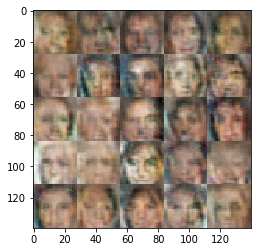

Epoch 0 The No. 3010 steps loss_d is 0.37685808539390564 The No. 3010 steps loss_g is 5.859018802642822
Epoch 0 The No. 3020 steps loss_d is 1.1670860052108765 The No. 3020 steps loss_g is 0.6339836120605469
Epoch 0 The No. 3030 steps loss_d is 0.3759671747684479 The No. 3030 steps loss_g is 5.738498210906982
Epoch 0 The No. 3040 steps loss_d is 0.4018956422805786 The No. 3040 steps loss_g is 3.957695245742798
Epoch 0 The No. 3050 steps loss_d is 0.35343417525291443 The No. 3050 steps loss_g is 5.767956256866455
Epoch 0 The No. 3060 steps loss_d is 0.416821151971817 The No. 3060 steps loss_g is 3.4833767414093018
Epoch 0 The No. 3070 steps loss_d is 0.4202345907688141 The No. 3070 steps loss_g is 3.3830935955047607
Epoch 0 The No. 3080 steps loss_d is 0.4035472869873047 The No. 3080 steps loss_g is 5.140632629394531
Epoch 0 The No. 3090 steps loss_d is 0.3863065838813782 The No. 3090 steps loss_g is 4.069243907928467
Epoch 0 The No. 3100 steps loss_d is 0.7564715147018433 The No. 3100 

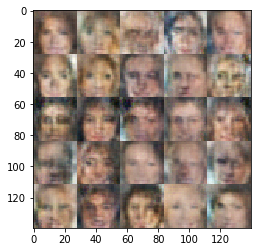

Epoch 0 The No. 3110 steps loss_d is 0.5682250261306763 The No. 3110 steps loss_g is 3.248722553253174
Epoch 0 The No. 3120 steps loss_d is 0.35440412163734436 The No. 3120 steps loss_g is 5.051046848297119
Epoch 0 The No. 3130 steps loss_d is 0.4055948853492737 The No. 3130 steps loss_g is 3.142146348953247
Epoch 0 The No. 3140 steps loss_d is 0.47902050614356995 The No. 3140 steps loss_g is 5.747415065765381
Epoch 0 The No. 3150 steps loss_d is 0.37561410665512085 The No. 3150 steps loss_g is 5.5496368408203125
Epoch 0 The No. 3160 steps loss_d is 0.3979376554489136 The No. 3160 steps loss_g is 3.8853554725646973


In [19]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.